In [1]:
import pandas as pd
import re
import unicodedata
import string
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import numpy as np

In [2]:
def load_dataset(file_path):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Please use CSV or Excel.")
    return df

# Example usage
file_path = "Spam_dataset.csv"  # or .xlsx
df = load_dataset(file_path)
text_column = "text"  

# Display the first few rows to verify
df.head()

,type,text,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,Promo,জিঅ 5G গ্ৰাহকসকলৰ বাবে বিশেষ অফাৰ\nজিঅ এয়াৰফা...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Promo,জিঅ'ফাইবাৰে আপোনাক স্বাস্থ্য আৰু ফিট্নেছ এপসমূ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ham,299.0 টকাৰ ৰিচাৰ্জ সফল হৈছে!\nJio নম্বৰ : 700...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Promo,Jio 'ৰ সৈতে সংযুক্ত হৈ থাকক আৰু Jio 'ৰ বিশ্বমা...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,promo,অতুলনীয় সেৱাৰ সৈতে ভাৰতৰ একমাত্ৰ প্ৰকৃত 5G নে...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def extract_phone_numbers(df, text_column):
    result_df = df.copy()
    result_df['has_phone_number'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Check for phone numbers (Indian format)
        phone_patterns = [
            r'\+?\d{2}\s*\d{10}',  # +91 XXXXXXXXXX or 91 XXXXXXXXXX
            r'\d{3,5}[-\s]?\d{6,7}',  # XXX-XXXXXXX or XXXXX XXXXXX
            r'\d{10,11}',  # XXXXXXXXXX (10 digits)
            r'\d{2,4}[-\s]?\d{6,8}',  # Landline numbers: XX-XXXXXXXX or XXXX XXXXXXX
            r'0\d{2,3}[-\s]?\d{6,8}',  # Landline with STD code: 0XX-XXXXXXXX
            r'\d{3,4}\s+\d{2}\s+\d{5}',  # Pattern like "0222 33 55555"
        ]
        
        # Convert Bengali/Assamese digits to Arabic digits for processing
        bengali_assamese_text = text
        digit_map = {
            '০': '0', '১': '1', '২': '2', '৩': '3', '৪': '4',
            '৫': '5', '৬': '6', '৭': '7', '৮': '8', '৯': '9'
        }
        
        for bn_digit, ar_digit in digit_map.items():
            bengali_assamese_text = bengali_assamese_text.replace(bn_digit, ar_digit)
        
        # Check patterns in both original and converted text
        for pattern in phone_patterns:
            if re.search(pattern, text) or re.search(pattern, bengali_assamese_text):
                result_df.at[idx, 'has_phone_number'] = 1
                break
    
    return result_df

# Apply phone number extraction
df = extract_phone_numbers(df, text_column)

# Display the count of messages with phone numbers
print(f"Messages with phone numbers: {df['has_phone_number'].sum()}")

Messages with phone numbers: 121


In [4]:
def extract_special_chars(df, text_column):
    result_df = df.copy()
    result_df['has_special_chars'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Check for special characters. Special characters that will be counted: '!', '"', '#', '$', '%', '&', ''', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\', ']', '^', '_', '`', '{', '|', '}', '~', '।', '॥', '॰', '৷'
        special_chars = set(string.punctuation)
        special_chars.discard('₹')  # Remove rupee symbol from special characters to add on other column
        
        if any(char in special_chars for char in text):
            result_df.at[idx, 'has_special_chars'] = 1
    
    return result_df

# Apply special character detection
df = extract_special_chars(df, text_column)

# Display the count of messages with special characters
print(f"Messages with special characters: {df['has_special_chars'].sum()}")

Messages with special characters: 2553


In [5]:
def extract_all_caps_words(df, text_column):
    result_df = df.copy()
    result_df['has_all_caps_words'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Consider only Latin script words (English)
        latin_words = re.findall(r'[A-Za-z]+', text)
        if latin_words and any(word.isupper() and len(word) > 1 for word in latin_words):
            result_df.at[idx, 'has_all_caps_words'] = 1
    
    return result_df

# Apply all caps words detection
df = extract_all_caps_words(df, text_column)

# Display the count of messages with all caps words
print(f"Messages with all capital words: {df['has_all_caps_words'].sum()}")

Messages with all capital words: 479


In [6]:
def extract_urls(df, text_column):
    result_df = df.copy()
    result_df['has_url'] = 0      # Flag for any type of URL
    result_df['has_short_url'] = 0 # Flag specifically for short URLs
    result_df['has_regular_url'] = 0 # New flag for regular (non-short) URLs
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Check for regular URLs
        regular_url_patterns = [
            r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+',  # http:// or https:// URLs
            r'www\.(?:[-\w.]|(?:%[\da-fA-F]{2}))+'       # www. URLs
        ]
        
        short_url_patterns = [
            r'bit\.ly/\S+', 
            r'goo\.gl/\S+', 
            r'tinyurl\.com/\S+',
            r't\.co/\S+'
        ]
        
        # Check for short URLs
        for pattern in short_url_patterns:
            if re.search(pattern, text):
                result_df.at[idx, 'has_short_url'] = 1
                result_df.at[idx, 'has_url'] = 1
                break
        
        # Check for regular URLs
        for pattern in regular_url_patterns:
            if re.search(pattern, text):
                # Check that this is not actually a match of a short URL
                match = re.search(pattern, text)
                matched_text = match.group(0)
                
                is_short_url = 0
                for short_pattern in short_url_patterns:
                    if re.search(short_pattern, matched_text):
                        is_short_url = 1
                        break
                
                if not is_short_url:
                    result_df.at[idx, 'has_regular_url'] = 1
                    result_df.at[idx, 'has_url'] = 1
                break
    
    return result_df

# Apply URL detection
df = extract_urls(df, text_column)

# Display the count of messages with URLs
print(f"Messages with any type of URL: {df['has_url'].sum()}")
print(f"Messages with short URLs: {df['has_short_url'].sum()}")
print(f"Messages with regular (non-short) URLs: {df['has_regular_url'].sum()}")

Messages with any type of URL: 426
Messages with short URLs: 192
Messages with regular (non-short) URLs: 257


In [7]:
def extract_mixed_language(df, text_column):
    result_df = df.copy()
    result_df['is_mixed_language'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        has_bengali_assamese = 0
        has_latin = bool(re.search(r'[A-Za-z]', text))
        
        # Check for Bengali/Assamese script
        for char in text:
            if 'BENGALI' in unicodedata.name(char, ''):
                has_bengali_assamese = 1
                break
            elif 'ASSAMESE' in unicodedata.name(char, ''):
                has_bengali_assamese = 1
                break
        
        if has_bengali_assamese and has_latin:
            result_df.at[idx, 'is_mixed_language'] = 1
    
    return result_df

# Apply mixed language detection
df = extract_mixed_language(df, text_column)

# Display the count of messages with mixed language
print(f"Messages with mixed language: {df['is_mixed_language'].sum()}")

Messages with mixed language: 1099


In [8]:
import re

def extract_currency(df, text_column):
    result_df = df.copy()
    result_df['has_currency'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Check for currency symbols and Western terms
        simple_patterns = [
            r'₹', r'रुपया', 
            r'Rs\.?', r'INR',
            r'\$', r'€', r'£', r'¥',
            r'dollar', r'euro', r'rupee'
        ]
        
        # Check simple patterns
        for pattern in simple_patterns:
            if re.search(pattern, text, re.IGNORECASE):
                result_df.at[idx, 'has_currency'] = 1
                break
        
        # If currency already detected, skip to next row
        if result_df.at[idx, 'has_currency'] == 1:
            continue
        
        # Combined Bengali and Assamese currency terms
        currency_terms = [
            'টাকা', 'টকা', 'পয়সা', 'পোইসা', 'তাকা',
            'টকা', 'টাকা', 'পইচা', 'পাই', 'ধন',
            'taka', 'toka', 'poisa', 'paisa','টকীয়া'
        ]
        
        # Check for exact matches
        for term in currency_terms:
            if term in text:
                result_df.at[idx, 'has_currency'] = 1
                break
                
        # If still not detected, try with suffixes
        if result_df.at[idx, 'has_currency'] == 0:
            for term in currency_terms:
                pattern = term + r'\w*'
                if re.search(pattern, text):
                    result_df.at[idx, 'has_currency'] = 1
                    break
    
    return result_df

df = extract_currency(df, text_column)
print(f"Messages with Currency: {df['has_currency'].sum()}")

Messages with Currency: 608


In [9]:
# import re
# import unicodedata
# import pandas as pd

# def extract_dates(df, text_column):
#     result_df = df.copy()
#     result_df['has_date'] = 0
#     #result_df['date'] = None  # New column to store the actual extracted date strings
    
#     # Process each row
#     for idx, row in df.iterrows():
#         text = str(row[text_column])
        
#         # Normalize Unicode to handle combining characters and diacritics properly
#         text = unicodedata.normalize('NFC', text)
        
#         # Check for dates in various formats
#         date_patterns = [
#             # DD/MM/YYYY, MM/DD/YYYY, YYYY/MM/DD
#             r'\d{1,2}[/.-]\d{1,2}[/.-]\d{2,4}',
            
#             # DD-MMM-YY format (e.g., 19-Jun-24)
#             r'\d{1,2}-(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)-\d{2}',
            
#             # Bengali dates with months in words (with possible suffixes) - with optional comma
#             r'\d{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর)(?:\w{0,3})?(?:,)?\s+\d{2,4}',
            
#             # Assamese dates with months in words (with possible suffixes) - with optional comma
#             r'\d{1,2}\s+(?:জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:\w{0,3})?(?:,)?\s+\d{2,4}',
            
#             # Month name first in Bengali/Assamese (with possible suffixes)
#             r'(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর)(?:\w{0,3})?\s+\d{1,2}(?:,)?\s+\d{2,4}',
#             r'(?:জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:\w{0,3})?\s+\d{1,2}(?:,)?\s+\d{2,4}',
            
#             # Text dates (English)
#             r'\d{1,2}\s+(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{2,4}',
#             r'\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{2,4}',
            
#             # Month name first in English
#             r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2}(?:,)?\s+\d{2,4}',
#             r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{1,2}(?:,)?\s+\d{2,4}',
            
#             # Year patterns
#             r'\d{4}\s*সাল',  # Bengali year
#             r'\d{4}\s*(?:year|বছর|বৰ্ষ)',  # Year in English or Bengali/Assamese
            
#             # Bengali/Assamese numerals in dates
#             r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+[১২৩৪৫৬৭৮৯০]{2,4}',
            
#             # Date with তারিখ/তাৰিখ variations (date indicator)
#             r'\d{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+\d{2,4}\s+(?:তারিখ(?:ে|ের|)|তাৰিখ(?:ে|ৰ|ত))',
            
#             # Bengali numerals with তারিখ/তাৰিখ
#             r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+[১২৩৪৫৬৭৮৯০]{2,4}\s+(?:তারিখ(?:ে|ের|)|তাৰিখ(?:ে|ৰ|ত))',
            
#             # Day suffixes in Bengali/Assamese (ই, ৰ, র)
#             r'(?:আজি|আজ|কালি|কাল|গতকালি|গতকাল|পরশু|পৰহি|যোৱা)\s+[১২৩৪৫৬৭৮৯০]{1,2}(?:ই|ৰ|র)?\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)',
            
#             # Specific date format with দিন/দিনত (day)
#             r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+[১২৩৪৫৬৭৮৯০]{2,4}\s+দিন(?:ত|ে)?',
            
#             # Specific format with মাস/মাহ (month)
#             r'(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)\s+মা(?:স|হ)',
            
#             # Bengali/Assamese dates with specific date indicators
#             r'(?:আজি|আজ|কালি|কাল|গতকালি|গতকাল|পরশু|পৰহি)\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+[১২৩৪৫৬৭৮৯০]{1,4}',
            
#             # NEW PATTERNS: Day and month followed by text and then year (to handle separated date components)
#             r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ).*?[১২৩৪৫৬৭৮৯০]{4}',
            
#             # NEW PATTERN: Day and month in the context of events with year (দিৱস/event pattern)
#             r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ).*?দিৱস.*?[১২৩৪৫৬৭৮৯০]{4}',
            
#             # NEW PATTERN: Specific pattern for International Migrant's Day type formats
#             r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)\s+(?:".*?"|\'.*?\').*?[১২৩৪৫৬৭৮৯০]{4}',
#         ]
        
#         # Additional contextual patterns that may indicate dates
#         context_patterns = [
#             # Relative date expressions
#             r'(?:আজি|আজ|কালি|কাল|গতকালি|গতকাল|পরশু|পৰহি|যোৱা)\s+[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:দিন|দিনত)',
#             r'(?:গত|বিগত|যোৱা|আহিবলগীয়া)\s+(?:সপ্তাহ|সপ্তাহত|সোমবাৰ|মঙ্গলবাৰ|বুধবাৰ|বৃহস্পতিবাৰ|শুক্ৰবাৰ|শনিবাৰ|ৰবিবাৰ|সোমবার|মঙ্গলবার|বুধবার|বৃহস্পতিবার|শুক্রবার|শনিবার|রবিবার)',
            
#             # Date related day markers
#             r'(?:সোমবাৰ|মঙ্গলবাৰ|বুধবাৰ|বৃহস্পতিবাৰ|শুক্ৰবাৰ|শনিবাৰ|ৰবিবাৰ|সোমবার|মঙ্গলবার|বুধবার|বৃহস্পতিবার|শুক্রবার|শনিবার|রবিবার)\s+[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)'
#         ]
        
#         date_found = False
#         date_text = None
        
#         # Check main date patterns
#         for pattern in date_patterns:
#             try:
#                 match = re.search(pattern, text, re.IGNORECASE)
#                 if match:
#                     date_text = match.group(0)
#                     result_df.at[idx, 'has_date'] = 1
#                    # result_df.at[idx, 'date'] = date_text
#                     date_found = True
#                     break
#             except Exception as e:
#                 print(f"Error with pattern: {pattern}")
#                 print(f"Error message: {e}")
#                 continue
        
#         # If no date found yet, check context patterns
#         if not date_found:
#             for pattern in context_patterns:
#                 try:
#                     match = re.search(pattern, text, re.IGNORECASE)
#                     if match:
#                         date_text = match.group(0)
#                         result_df.at[idx, 'has_date'] = 1
#                       #  result_df.at[idx, 'date'] = date_text
#                         break
#                 except Exception as e:
#                     print(f"Error with context pattern: {pattern}")
#                     print(f"Error message: {e}")
#                     continue
    
#     return result_df

#     # First, run this to add the 'has_date' column
# df = extract_dates(df, 'text')  # Replace with your actual text column name
    
#     # Display the count of messages with dates
# date_count = df['has_date'].sum()
# print(f"Messages with date: {date_count}")
    

Messages with date: 369


In [18]:
import re
import unicodedata
import pandas as pd

def extract_temporal_info(df, text_column):
    result_df = df.copy()
    result_df['has_temporal'] = 0
    result_df['has_date'] = 0
    result_df['has_time'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Normalize Unicode to handle combining characters and diacritics properly
        text = unicodedata.normalize('NFC', text)
        
        # Check for dates
        # Date patterns - extensive list from first function
        date_patterns = [
            # DD/MM/YYYY, MM/DD/YYYY, YYYY/MM/DD
            r'\d{1,2}[/.-]\d{1,2}[/.-]\d{2,4}',
            
            # DD-MMM-YY format (e.g., 19-Jun-24)
            r'\d{1,2}-(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)-\d{2}',
            
            # Bengali dates with months in words (with possible suffixes) - with optional comma
            r'\d{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর)(?:\w{0,3})?(?:,)?\s+\d{2,4}',
            
            # Assamese dates with months in words (with possible suffixes) - with optional comma
            r'\d{1,2}\s+(?:জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:\w{0,3})?(?:,)?\s+\d{2,4}',
            
            # Month name first in Bengali/Assamese (with possible suffixes)
            r'(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর)(?:\w{0,3})?\s+\d{1,2}(?:,)?\s+\d{2,4}',
            r'(?:জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:\w{0,3})?\s+\d{1,2}(?:,)?\s+\d{2,4}',
            
            # Text dates (English)
            r'\d{1,2}\s+(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{2,4}',
            r'\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{2,4}',
            
            # Month name first in English
            r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2}(?:,)?\s+\d{2,4}',
            r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{1,2}(?:,)?\s+\d{2,4}',
            
            # Year patterns
            r'\d{4}\s*সাল',  # Bengali year
            r'\d{4}\s*(?:year|বছর|বৰ্ষ)',  # Year in English or Bengali/Assamese
            
            # Bengali/Assamese numerals in dates
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+[১২৩৪৫৬৭৮৯০]{2,4}',
            
            # Date with তারিখ/তাৰিখ variations (date indicator)
            r'\d{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+\d{2,4}\s+(?:তারিখ(?:ে|ের|)|তাৰিখ(?:ে|ৰ|ত))',
            
            # Bengali numerals with তারিখ/তাৰিখ
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+[১২৩৪৫৬৭৮৯০]{2,4}\s+(?:তারিখ(?:ে|ের|)|তাৰিখ(?:ে|ৰ|ত))',
            
            # Day suffixes in Bengali/Assamese (ই, ৰ, র)
            r'(?:আজি|আজ|কালি|কাল|গতকালি|গতকাল|পরশু|পৰহি|যোৱা)\s+[১২৩৪৫৬৭৮৯০]{1,2}(?:ই|ৰ|র)?\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)',
            
            # Specific date format with দিন/দিনত (day)
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+[১২৩৪৫৬৭৮৯০]{2,4}\s+দিন(?:ত|ে)?',
            
            # Specific format with মাস/মাহ (month)
            r'(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)\s+মা(?:স|হ)',
            
            # Bengali/Assamese dates with specific date indicators
            r'(?:আজি|আজ|কালি|কাল|গতকালি|গতকাল|পরশু|পৰহি)\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+[১২৩৪৫৬৭৮৯০]{1,4}',
            
            # Day and month followed by text and then year (to handle separated date components)
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ).*?[১২৩৪৫৬৭৮৯০]{4}',
            
            # Day and month in the context of events with year (দিৱস/event pattern)
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ).*?দিৱস.*?[১২৩৪৫৬৭৮৯০]{4}',
            
            # Specific pattern for International Migrant's Day type formats
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)\s+(?:".*?"|\'.*?\').*?[১২৩৪৫৬৭৮৯০]{4}',
        ]
        
        # Additional contextual patterns that may indicate dates
        date_context_patterns = [
            # Relative date expressions
            r'(?:আজি|আজ|কালি|কাল|গতকালি|গতকাল|পরশু|পৰহি|যোৱা)\s+[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:দিন|দিনত)',
            r'(?:গত|বিগত|যোৱা|আহিবলগীয়া)\s+(?:সপ্তাহ|সপ্তাহত|সোমবাৰ|মঙ্গলবাৰ|বুধবাৰ|বৃহস্পতিবাৰ|শুক্ৰবাৰ|শনিবাৰ|ৰবিবাৰ|সোমবার|মঙ্গলবার|বুধবার|বৃহস্পতিবার|শুক্রবার|শনিবার|রবিবার)',
            
            # Date related day markers
            r'(?:সোমবাৰ|মঙ্গলবাৰ|বুধবাৰ|বৃহস্পতিবাৰ|শুক্ৰবাৰ|শনিবাৰ|ৰবিবাৰ|সোমবার|মঙ্গলবার|বুধবার|বৃহস্পতিবার|শুক্রবার|শনিবার|রবিবার)\s+[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)'
        ]
        
        # Time patterns - from second function
        # English time patterns
        english_time_patterns = [
            # 12-hour format with am/pm
            r'\b([0-9]|0[0-9]|1[0-2])(?::([0-5][0-9]))?(?::([0-5][0-9]))?\s*([AaPp][Mm])\b',
            # 12-hour variations with dot/space between numbers and am/pm
            r'\b([0-9]|0[0-9]|1[0-2])(?:\.|\s)([0-5][0-9])(?:\s*|\.)([AaPp]\.?[Mm]\.?)\b',
            # 24-hour format 
            r'\b([01]?[0-9]|2[0-3]):([0-5][0-9])(?::([0-5][0-9]))?\b',
            # Words like "noon", "midnight"
            r'\b(noon|midnight|midday)\b',
            # Time words with numbers
            r'\b([0-9]|0[0-9]|1[0-2])\s+o\'?clock\b',
            # Half and quarter phrasing
            r'\b(half|quarter)\s+(past|to)\s+([0-9]|0[0-9]|1[0-2])\b',
            # Hour variations
            r'\bat\s+([0-9]|0[0-9]|1[0-2])(?:\s+|\:)([0-5][0-9])?\s*([AaPp][Mm])?\b'
        ]
        
        # Bengali/Assamese time patterns (numeric)
        bn_as_numeric_time_patterns = [
            # Hours and minutes with Bengali/Assamese digits
            r'[০-৯]{1,2}(?:[:\.।]|\s*ঃ|\s+)[০-৯]{1,2}(?:[:\.।]|\s*ঃ|\s+)?[০-৯]{0,2}',
            # Hours with Bengali/Assamese digits followed by টা/বাজে/ঘণ্টা/घंटा
            r'[০-৯]{1,2}\s*(?:টা|বাজে|ঘণ্টা|घंटा)'
        ]
        
        # Bengali/Assamese time keywords
        bn_as_time_words = [
            # Time-related Bengali/Assamese words
            'সকাল', 'ভোর', 'রাত', 'বিকাল', 'সন্ধ্যা', 'দুপুর',  # Bengali time periods
            'ৰাতি', 'পুৱা', 'গধূলি', 'আবেলি', 'নিশা', 'দুপৰীয়া',  # Assamese time periods
            'টা', 'বাজে', 'ঘণ্টা', 'মিনিট', 'সেকেন্ড',  # Bengali units
            'বজি', 'বাজি', 'ঘণ্টা', 'মিনিট', 'ছেকেণ্ড'  # Assamese units
        ]
        
        # Bengali/Assamese time phrases
        time_phrases = [
            r'(?:এখন|বর্তমান|এতিয়া)\s+[০-৯]{1,2}\s*(?:টা|বাজে|ঘণ্টা|বজি)',
            r'(?:সকাল|ভোর|রাত|বিকাল|সন্ধ্যা|দুপুর|ৰাতি|পুৱা|গধূলি|আবেলি|নিশা|দুপৰীয়া)\s+[০-৯]{1,2}',
            r'[০-৯]{1,2}\s*(?:টা|বাজে|ঘণ্টা)\s*(?:ও|আৰু|এবং)?\s*[০-৯]{1,2}\s*(?:মিনিট|মিনিট)',
            # Early/late variations
            r'(?:ভোরে|ভোৰত|সকালে|সকালত|রাতে|ৰাতিত)\s+[০-৯]{1,2}',
            # AM/PM in Bengali/Assamese
            r'[০-৯]{1,2}(?:[:\.।]|\s*ঃ|\s+)[০-৯]{1,2}\s*(?:এএম|পিএম|am|pm|a\.m\.|p\.m\.)'
        ]
        
        date_found = False
        time_found = False
        
        # Check for dates
        for pattern in date_patterns:
            try:
                if re.search(pattern, text, re.IGNORECASE):
                    result_df.at[idx, 'has_date'] = 1
                    date_found = True
                    break
            except Exception as e:
                print(f"Error with date pattern: {pattern}")
                print(f"Error message: {e}")
                continue
        
        # If no date found yet, check date context patterns
        if not date_found:
            for pattern in date_context_patterns:
                try:
                    if re.search(pattern, text, re.IGNORECASE):
                        result_df.at[idx, 'has_date'] = 1
                        date_found = True
                        break
                except Exception as e:
                    print(f"Error with date context pattern: {pattern}")
                    print(f"Error message: {e}")
                    continue
        
        # Check for time - English patterns
        for pattern in english_time_patterns:
            try:
                if re.search(pattern, text, re.IGNORECASE):
                    result_df.at[idx, 'has_time'] = 1
                    time_found = True
                    break
            except Exception as e:
                print(f"Error with English time pattern: {pattern}")
                print(f"Error message: {e}")
                continue
        
        # Check for time - Bengali/Assamese numeric patterns
        if not time_found:
            for pattern in bn_as_numeric_time_patterns:
                try:
                    if re.search(pattern, text):
                        result_df.at[idx, 'has_time'] = 1
                        time_found = True
                        break
                except Exception as e:
                    print(f"Error with Bengali/Assamese numeric time pattern: {pattern}")
                    print(f"Error message: {e}")
                    continue
        
        # Check for combination of Bengali/Assamese digits with time words
        if not time_found:
            try:
                if any(re.search(r'[০-৯]{1,2}\s*' + word, text) for word in bn_as_time_words):
                    result_df.at[idx, 'has_time'] = 1
                    time_found = True
            except Exception as e:
                print(f"Error with Bengali/Assamese time words check")
                print(f"Error message: {e}")
        
        # Check for time-related phrases
        if not time_found:
            for pattern in time_phrases:
                try:
                    if re.search(pattern, text, re.IGNORECASE):
                        result_df.at[idx, 'has_time'] = 1
                        time_found = True
                        break
                except Exception as e:
                    print(f"Error with time phrase pattern: {pattern}")
                    print(f"Error message: {e}")
                    continue
        
        # Set 'has_temporal' if either date or time is found
        if date_found or time_found:
            result_df.at[idx, 'has_temporal'] = 1
    
    return result_df

# Apply dateTime detection
df = extract_temporal_info(df, text_column)

# Display the count of messages with dateTime
print(f"Messages with date/Time information: {df['has_date/Time'].sum()}")

KeyError: 'has_date/Time'

In [10]:
def extract_id_codes(df, text_column):
    result_df = df.copy()
    result_df['has_id_code'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Check for ID codes (more than 10 digits)
        id_pattern = r'\b\w*\d{10,}\w*\b'
        if re.search(id_pattern, text):
            result_df.at[idx, 'has_id_code'] = 1
    
    return result_df

# Apply ID code detection
df = extract_id_codes(df, text_column)

# Display the count of messages with ID codes
print(f"Messages with ID codes: {df['has_id_code'].sum()}")

Messages with ID codes: 110


In [11]:
def extract_emojis(df, text_column):
    result_df = df.copy()
    result_df['has_emoji'] = 0
    
    # Import regex for emoji detection
    import re
    
    # Unicode ranges for emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0000257F"  # Enclosed characters
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U00002700-\U000027BF"  # Dingbats
        "\U0000FE0F"             # Variation Selector
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "]+", 
        flags=re.UNICODE
    )
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Check for emojis
        if emoji_pattern.search(text):
            result_df.at[idx, 'has_emoji'] = 1
    
    return result_df

# Apply emoji detection
df = extract_emojis(df, text_column)

# Display the count of messages with emojis
print(f"Messages with emojis: {df['has_emoji'].sum()}")

Messages with emojis: 47


In [12]:
# import re
# import pandas as pd

# def extract_time(df, text_column):
#     result_df = df.copy()
#     result_df['has_time'] = 0
    
#     # Process each row
#     for idx, row in df.iterrows():
#         text = str(row[text_column])
        
#         # English time patterns
#         english_patterns = [
#             # 12-hour format with am/pm
#             r'\b([0-9]|0[0-9]|1[0-2])(?::([0-5][0-9]))?(?::([0-5][0-9]))?\s*([AaPp][Mm])\b',
#             # 12-hour variations with dot/space between numbers and am/pm
#             r'\b([0-9]|0[0-9]|1[0-2])(?:\.|\s)([0-5][0-9])(?:\s*|\.)([AaPp]\.?[Mm]\.?)\b',
#             # 24-hour format 
#             r'\b([01]?[0-9]|2[0-3]):([0-5][0-9])(?::([0-5][0-9]))?\b',
#             # Words like "noon", "midnight"
#             r'\b(noon|midnight|midday)\b',
#             # Time words with numbers
#             r'\b([0-9]|0[0-9]|1[0-2])\s+o\'?clock\b',
#             # Half and quarter phrasing
#             r'\b(half|quarter)\s+(past|to)\s+([0-9]|0[0-9]|1[0-2])\b',
#             # Hour variations
#             r'\bat\s+([0-9]|0[0-9]|1[0-2])(?:\s+|\:)([0-5][0-9])?\s*([AaPp][Mm])?\b'
#         ]
        
#         # Bengali/Assamese time patterns (numeric)
#         # Bengali digits: ০ ১ ২ ৩ ৪ ৫ ৬ ৭ ৮ ৯
#         # Assamese digits: ০ ১ ২ ৩ ৪ ৫ ৬ ৭ ৮ ৯ (same as Bengali)
#         bn_as_numeric_patterns = [
#             # Hours and minutes with Bengali/Assamese digits
#             r'[০-৯]{1,2}(?:[:\.।]|\s*ঃ|\s+)[০-৯]{1,2}(?:[:\.।]|\s*ঃ|\s+)?[০-৯]{0,2}',
#             # Hours with Bengali/Assamese digits followed by টা/বাজে/ঘণ্টা/घंटा
#             r'[০-৯]{1,2}\s*(?:টা|বাজে|ঘণ্টা|घंटा)'
#         ]
        
#         # Bengali/Assamese time keywords
#         bn_as_time_words = [
#             # Time-related Bengali/Assamese words
#             'সকাল', 'ভোর', 'রাত', 'বিকাল', 'সন্ধ্যা', 'দুপুর',  # Bengali time periods
#             'ৰাতি', 'পুৱা', 'গধূলি', 'আবেলি', 'নিশা', 'দুপৰীয়া',  # Assamese time periods
#             'টা', 'বাজে', 'ঘণ্টা', 'মিনিট', 'সেকেন্ড',  # Bengali units
#             'বজি', 'বাজি', 'ঘণ্টা', 'মিনিট', 'ছেকেণ্ড'  # Assamese units
#         ]
        
#         # Combined approach for time detection
#         time_detected = False
        
#         # Check English patterns
#         for pattern in english_patterns:
#             if re.search(pattern, text, re.IGNORECASE):
#                 result_df.at[idx, 'has_time'] = 1
#                 time_detected = True
#                 break
        
#         if time_detected:
#             continue
        
#         # Check Bengali/Assamese numeric patterns
#         for pattern in bn_as_numeric_patterns:
#             if re.search(pattern, text):
#                 result_df.at[idx, 'has_time'] = 1
#                 time_detected = True
#                 break
        
#         if time_detected:
#             continue
        
#         # Check for combination of Bengali/Assamese digits with time words
#         if any(re.search(r'[০-৯]{1,2}\s*' + word, text) for word in bn_as_time_words):
#             result_df.at[idx, 'has_time'] = 1
#             time_detected = True
#             continue
        
#         # Check for time-related phrases
#         # Bengali/Assamese phrases like "এখন ২টা বাজে" (It's 2 o'clock now)
#         # or "সকাল ৯টা" (9 in the morning)
#         time_phrases = [
#             r'(?:এখন|বর্তমান|এতিয়া)\s+[০-৯]{1,2}\s*(?:টা|বাজে|ঘণ্টা|বজি)',
#             r'(?:সকাল|ভোর|রাত|বিকাল|সন্ধ্যা|দুপুর|ৰাতি|পুৱা|গধূলি|আবেলি|নিশা|দুপৰীয়া)\s+[০-৯]{1,2}',
#             r'[০-৯]{1,2}\s*(?:টা|বাজে|ঘণ্টা)\s*(?:ও|আৰু|এবং)?\s*[০-৯]{1,2}\s*(?:মিনিট|মিনিট)',
#             # Early/late variations
#             r'(?:ভোরে|ভোৰত|সকালে|সকালত|রাতে|ৰাতিত)\s+[০-৯]{1,2}',
#             # AM/PM in Bengali/Assamese
#             r'[০-৯]{1,2}(?:[:\.।]|\s*ঃ|\s+)[০-৯]{1,2}\s*(?:এএম|পিএম|am|pm|a\.m\.|p\.m\.)'
#         ]
        
#         for pattern in time_phrases:
#             if re.search(pattern, text, re.IGNORECASE):
#                 result_df.at[idx, 'has_time'] = 1
#                 time_detected = True
#                 break
                
#     return result_df

# # Apply emoji detection
# df = extract_time(df, text_column)

# # Display the count of messages with emojis
# print(f"Messages with time: {df['has_time'].sum()}")

Messages with time: 405



Feature Summary:
has_phone_number: 121 instances
has_special_chars: 2553 instances
has_all_caps_words: 479 instances
has_url: 426 instances
has_short_url: 192 instances
has_regular_url: 257 instances
is_mixed_language: 1099 instances
has_currency: 608 instances
has_date: 369 instances
has_id_code: 110 instances
has_emoji: 47 instances


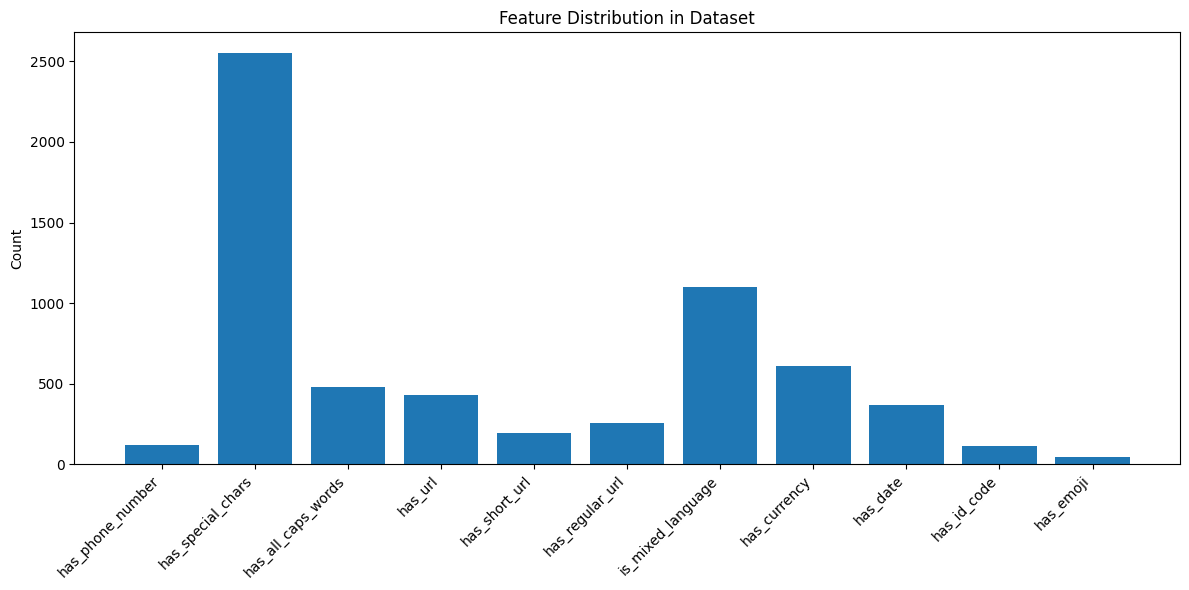

In [13]:
def generate_summary(df):
    feature_columns = [
        'has_phone_number', 'has_special_chars', 'has_all_caps_words','has_url', 
        'has_short_url', 'has_regular_url', 'is_mixed_language', 
        'has_currency', 'has_date', 'has_id_code','has_emoji'
    ]
    
    summary = {col: df[col].sum() for col in feature_columns}
    
    print("\nFeature Summary:")
    for feature, count in summary.items():
        print(f"{feature}: {count} instances")
    
    # Plot the summary
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    plt.bar(summary.keys(), summary.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('Feature Distribution in Dataset')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Generate and display summary
generate_summary(df)

In [14]:
def clean_dataframe(df):
    # Drop any unnamed columns that might have been created during processing
    unnamed_cols = [col for col in df.columns if 'Unnamed:' in str(col)]
    if unnamed_cols:
        df = df.drop(columns=unnamed_cols)
        print(f"Removed {len(unnamed_cols)} unnamed columns")
    return df

In [15]:
def save_dataset(df, output_file):
    # Make a copy of the dataframe to avoid modifying the original
    output_df = df.copy()
    
    # Ensure text columns are properly encoded
    text_columns = [col for col in output_df.columns if output_df[col].dtype == 'object']
    for col in text_columns:
        # Replace any problematic characters that can't be encoded
        output_df[col] = output_df[col].astype(str).apply(
            lambda x: x.encode('utf-8', errors='replace').decode('utf-8')
        )
    
    # Save with UTF-8 encoding explicitly specified
    output_df.to_csv(output_file, index=False, encoding='utf-8')
    
    print(f"Processing complete. Output saved to {output_file} with UTF-8 encoding")
    
    # Optional: Also save a backup in Excel format which handles Unicode better
    excel_file = output_file.replace('.csv', '.xlsx')
    try:
        output_df.to_excel(excel_file, index=False)
        print(f"Backup saved to Excel file: {excel_file}")
    except Exception as e:
        print(f"Could not save Excel backup: {e}")

# Save the processed dataset
df = clean_dataframe(df)

# Save the processed dataset
output_file = "processed_dataset.csv"
save_dataset(df, output_file)

Removed 13 unnamed columns
Processing complete. Output saved to processed_dataset.csv with UTF-8 encoding
Backup saved to Excel file: processed_dataset.xlsx
